# 의사결정트리회귀 모델을 사용한 버닝과 데드풀2 관객 수 예측

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz as eg
import graphviz

In [8]:
movie_data=pd.read_excel('mdata.xlsx',encoding='utf-8')

In [9]:
movie_data.head()

,순번,영화명,감독,배급사,개봉일,전국스크린수,전국관객수,장르,등급
0,1,명량,김한민,씨제이이앤엠(주),2014-07-30,1587,17613682,사극,15세이상관람가
1,2,신과함께-죄와 벌,김용화,롯데쇼핑㈜롯데엔터테인먼트,2017-12-20,1912,14411047,판타지,12세이상관람가
2,3,국제시장,윤제균,씨제이이앤엠(주),2014-12-17,966,14245998,드라마,12세이상관람가
3,4,아바타,제임스 카메론,이십세기폭스코리아(주),2009-12-17,912,13624328,SF,12세이상관람가
4,5,베테랑,류승완,씨제이이앤엠(주),2015-08-05,1064,13395400,액션,15세이상관람가


개봉 월이 영화관객수에 영향이 있다고 판단하여 월만 추출하였다

In [10]:
month_list=[movie_data['개봉일'][i][5:7] for i in range(movie_data.shape[0])]

In [11]:
movie_data['month']=month_list

감독, 배급사, 월, 전국스크린수, 장르, 등급을 feature로 보고 해당 값들을 열로 변환하여 새로운 dummy_data라는 데이터프레임에 저장

In [12]:
dummy_data=pd.get_dummies(movie_data['감독'])

In [13]:
dummy_data = pd.concat([pd.get_dummies(movie_data['감독']), pd.get_dummies(movie_data['배급사']),pd.get_dummies(movie_data['장르']),pd.get_dummies(movie_data['등급'])], axis=1)

In [14]:
dummy_data.head()

,BC 퍼트니,C. 토마스 하우웰,C.나가후쿠,D.J. 카루소,D.R. 후드,F. 게리 그레이,H.M. 콕클리,J 블레이크슨,J.C 챈더,J.J. 에이브럼스,...,12세관람가,12세이상관람가,"12세이상관람가,전체관람가",15세관람가,"15세관람가,12세이상관람가",15세이상관람가,"15세이상관람가,전체관람가",18세관람가,전체관람가,청소년관람불가
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


스크린수, 월과 타겟 값인 전국관객수도 dummy_data에 추가

In [15]:
dummy_data=pd.concat([dummy_data,movie_data['전국스크린수'],movie_data['month'],movie_data['전국관객수']],axis=1)

In [16]:
dummy_data.head()

,BC 퍼트니,C. 토마스 하우웰,C.나가후쿠,D.J. 카루소,D.R. 후드,F. 게리 그레이,H.M. 콕클리,J 블레이크슨,J.C 챈더,J.J. 에이브럼스,...,15세관람가,"15세관람가,12세이상관람가",15세이상관람가,"15세이상관람가,전체관람가",18세관람가,전체관람가,청소년관람불가,전국스크린수,month,전국관객수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1587,07,17613682
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1912,12,14411047
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,966,12,14245998
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,912,12,13624328
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1064,08,13395400


전국 관객수를 제외한 feature들을 관객 예측 변인으로 지정, train_test_split을 통해 훈련데이터 셋과 테스트데이터 셋을 만듬

In [17]:
movie_predictors=dummy_data.columns[:-1]

In [18]:
y=dummy_data['전국관객수']

In [19]:
X=dummy_data[movie_predictors]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

DecisionTreeRegressor를 불러오고, 모델을 만듬. 과적합과 일반성을 고려하여 max_depth를 바꾸면서 적절한 값을 구해서 넣음

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
movie_pre_model = DecisionTreeRegressor(max_depth=15)

train 데이터를훈련시키고 정확도를 확인, test 데이터 역시 마찬가지로 확인함

In [23]:
movie_pre_model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [24]:
movie_pre_model.score(X_train,y_train)

0.9575329540197179

In [25]:
movie_pre_model.fit(X_test,y_test)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [26]:
movie_pre_model.score(X_test,y_test)

0.9352563773793303

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [29]:
enc_list=[]

In [30]:
le.fit(movie_data['감독'].tolist())
enc_list.append(le.transform(movie_data['감독'].tolist()))

In [32]:
le.fit(movie_data['배급사'].tolist())
enc_list.append(le.transform(movie_data['배급사'].tolist()))

In [31]:
month_list=[movie_data['개봉일'][i][5:7] for i in range(movie_data.shape[0])]
le.fit(month_list)
enc_list.append(le.transform(month_list))

In [33]:
le.fit(movie_data['장르'].tolist())
enc_list.append(le.transform(movie_data['장르'].tolist()))

In [34]:
le.fit(movie_data['등급'].tolist())
enc_list.append(le.transform(movie_data['등급'].tolist()))

In [35]:
enc.fit(enc_list)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

버닝과 데드풀2의 특징들을 모델에 맞게 만들어야하므로 감독, 배급사, 장르, 등급, 월, 스크린수를 지정

참고그림 : 의사결정트리 그림

In [37]:
eg(movie_pre_model,out_file='tree.dot')

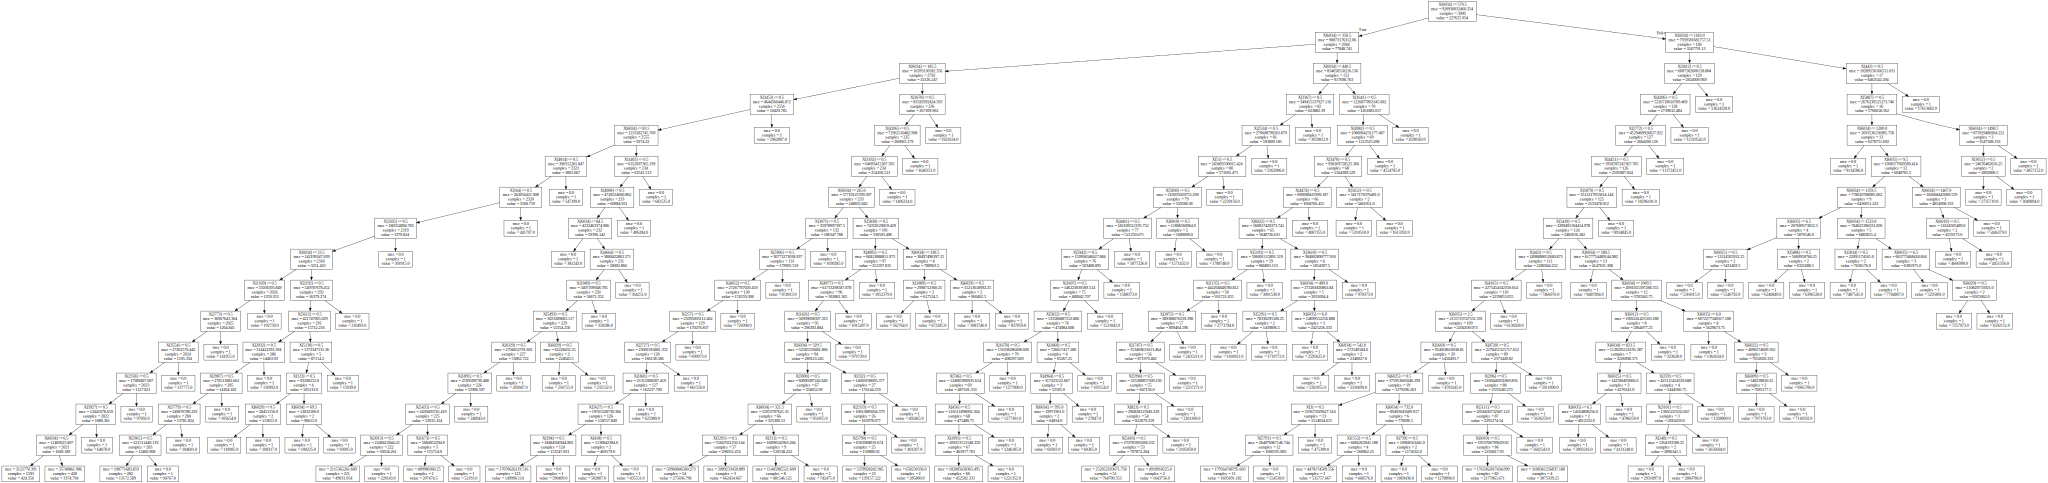

In [38]:
with open('tree.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))